In [82]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

import tensorflow as tf
print("TensorFlow version:", tf.__version__) #Printing tensorflow version to ensure library correctly installed

TensorFlow version: 2.16.1


In [83]:
df_medical_data = pd.read_csv('./Medicaldataset.csv') #Initialise dataframe from Medicaldataset.csv
df_medical_data.head(10) #Printing the first 10 rows of the dataset (dataset has 1319 rows)

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,63,1,66,160,83,160.0,1.80,0.012,negative
1,20,1,94,98,46,296.0,6.75,1.060,positive
2,56,1,64,160,77,270.0,1.99,0.003,negative
3,66,1,70,120,55,270.0,13.87,0.122,positive
4,54,1,64,112,65,300.0,1.08,0.003,negative
5,52,0,61,112,58,87.0,1.83,0.004,negative
6,38,0,40,179,68,102.0,0.71,0.003,negative
7,61,1,60,214,82,87.0,300.00,2.370,positive
8,49,0,60,154,81,135.0,2.35,0.004,negative
9,65,1,61,160,95,100.0,2.84,0.011,negative


In [84]:
df_medical_data.Result.value_counts()

Result
positive    810
negative    509
Name: count, dtype: int64

Based of the available labels in the 'Result' column we can see that on the 'positive' and 'negative' labels are present hence we are dealing with a binary classification model.

In [85]:
df_medical_data.shape


(1319, 9)

In [86]:
def column_min_max(df, column):
    min_value = df[column].min()
    max_value = df[column].max()
    print(f"'{column}' range is [{min_value} , {max_value}]")

columns = ['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']

for column in columns:
    column_min_max(df_medical_data, column)

'Age' range is [14 , 103]
'Gender' range is [0 , 1]
'Heart rate' range is [20 , 1111]
'Systolic blood pressure' range is [42 , 223]
'Diastolic blood pressure' range is [38 , 154]
'Blood sugar' range is [35.0 , 541.0]
'CK-MB' range is [0.321 , 300.0]
'Troponin' range is [0.001 , 10.3]


### Normalisation of data:

##### 'Result' converted to 0.0 for negative and 1.0 for positive.

##### All other columns aside from 'Gender" are scaled to between 0.0 and 1.0

In [87]:
df_medical_data['Result'] = df_medical_data['Result'].replace({'negative': 0, 'positive': 1})

scaler = MinMaxScaler()
df_medical_data[['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin', 'Result']] = scaler.fit_transform(df_medical_data[['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin', 'Result']])

df_medical_data.head(10)

C:\Users\Reece Lazarus\AppData\Local\Temp\ipykernel_6592\4011696001.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_medical_data['Result'] = df_medical_data['Result'].replace({'negative': 0, 'positive': 1})


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.550562,1.0,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0.0
1,0.067416,1.0,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1.0
2,0.471910,1.0,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0.0
3,0.584270,1.0,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1.0
4,0.449438,1.0,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0.0
5,0.426966,0.0,0.037580,0.386740,0.172414,0.102767,0.005035,0.000291,0.0
6,0.269663,0.0,0.018332,0.756906,0.258621,0.132411,0.001298,0.000194,0.0
7,0.528090,1.0,0.036664,0.950276,0.379310,0.102767,1.000000,0.230022,1.0
8,0.393258,0.0,0.036664,0.618785,0.370690,0.197628,0.006771,0.000291,0.0
9,0.573034,1.0,0.037580,0.651934,0.491379,0.128458,0.008406,0.000971,0.0


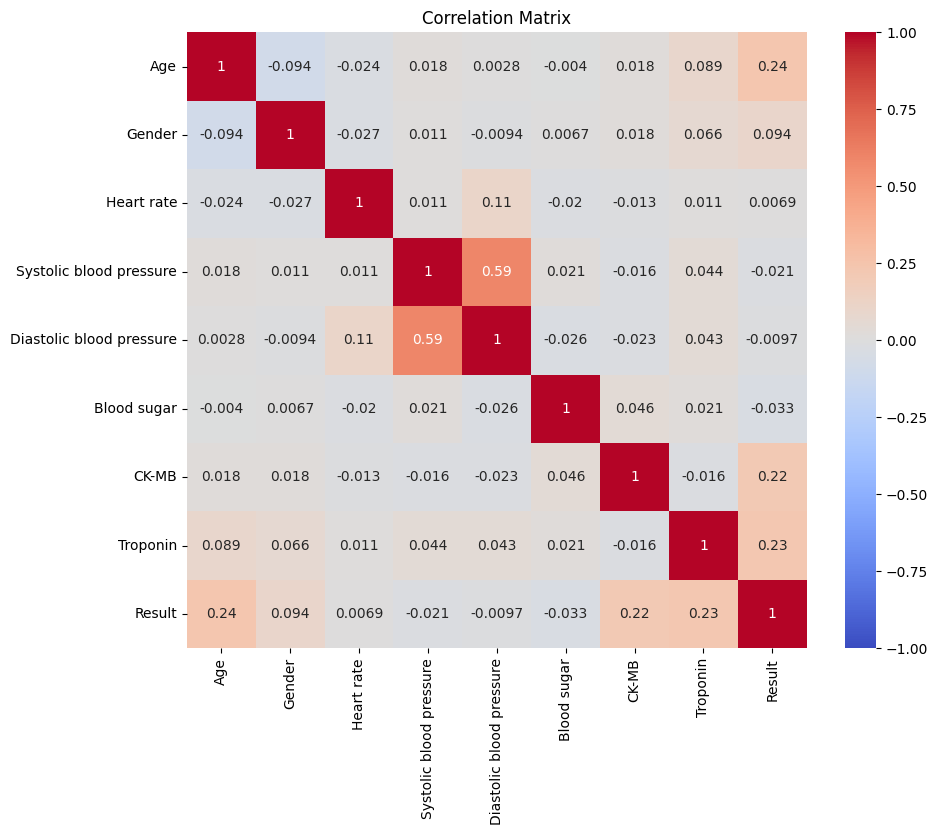

In [88]:
correlation_matrix = df_medical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

##### Begin splitting data and forming training, validation and test sets

In [89]:
#Split dataframe into input and output sets.
y = df_medical_data['Result'] 
X = df_medical_data.drop('Result', axis=1)

y = to_categorical(y) #one-hot encoding as opposed to simply using 0 or 1

# random_state=42 makes sures the RNG used by train_test_split is initialized to the same state everytime and ensures that the data is always split the same way
# Ratio split is Train:Validation:Test = 60:20:20
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=df_medical_data['Result'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape) #Ensuring the size of the input and output for each set match

(791, 8) (791, 2) (264, 8) (264, 2) (264, 8) (264, 2)


c:\Users\Reece Lazarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6158 - loss: 0.6546 - val_accuracy: 0.6591 - val_loss: 0.6349
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6647 - loss: 0.6095 - val_accuracy: 0.6439 - val_loss: 0.6155
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6946 - loss: 0.5567 - val_accuracy: 0.6932 - val_loss: 0.5699
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7191 - loss: 0.5231 - val_accuracy: 0.7348 - val_loss: 0.5334
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7261 - loss: 0.4953 - val_accuracy: 0.7311 - val_loss: 0.5395
Epoch 6/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7596 - loss: 0.4736 - val_accuracy: 0.7576 - val_loss: 0.5069
Epoch 7/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8039 - loss: 0.4181 - val_accuracy: 0.7765 - val_loss: 0.4736
Epoch 8/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7817 - loss: 0.4335 - val_accuracy: 0.6

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,368 (247.54 KB)

 Trainable params: 21,122 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,246 (165.03 KB)

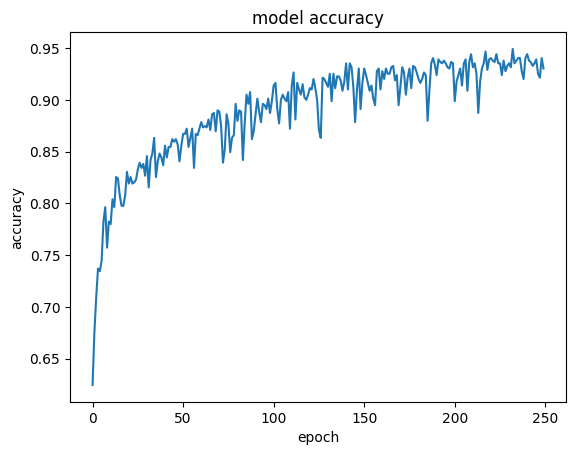

In [90]:
model = Sequential()

model.add(Dense(32, activation='tanh', input_dim=X_train.shape[1])) #input_dim=X_train.shape[1]
model.add(Dense(64, activation='linear')) 
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='tanh')) 
model.add(Dense(2, activation='softmax')) #2 nodes used in output layer because we're doing binary classification 

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_val, y_val))

model.summary()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [91]:
test_loss, test_accuracy = model.evaluate(X_test,  y_test, verbose = 0)

print('\nTest accuracy:', test_accuracy)
print('\nLoss:', test_loss)


Test accuracy: 0.9583333134651184

Loss: 0.16460034251213074


In [92]:
# Obtain predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

# Calculate Precision, Recall and F1 score
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted') 
f1 = f1_score(y_test, y_pred, average='weighted') 

print('\nPrecision:', precision) 
print('Recall:', recall) 
print('F1 Score:', f1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Precision: 0.9586548552379777
Recall: 0.9583333333333334
F1 Score: 0.958126498755174


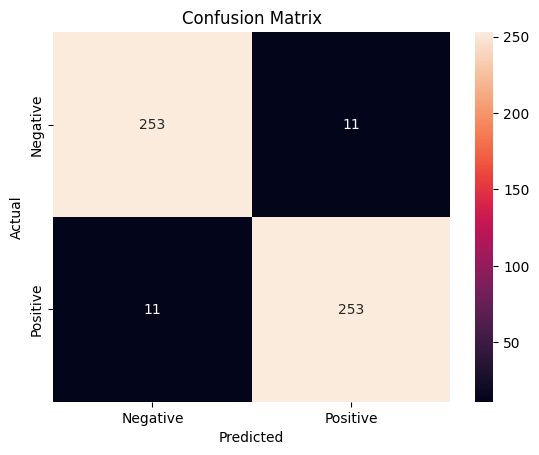

In [93]:
# Create a confusion matrix
y_test = y_test.ravel()
y_pred = y_pred.ravel()
cm = confusion_matrix(y_test, y_pred)

# Create labels for the confusion matrix
labels = ['Negative', 'Positive']
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()